This colab implements the KIP (Kernel Inducing Point) and is from [KIP Github](https://github.com/google-research/google-research/tree/master/kip). 
Our contribution are experiments on the PCAM dataset.

In [1]:
import torch
from torchvision.datasets import PCAM
from torchvision import transforms
from PIL import Image
from collections import Counter
import os
!pip install -q git+https://www.github.com/google/neural-tangents
import neural_tangents as nt
from neural_tangents import stax

import dataclasses
import functools
from typing import Callable, Optional

from jax.example_libraries import optimizers
import jax
import jax.config
from jax.config import config as jax_config
jax_config.update('jax_enable_x64', True) # for numerical stability, can disable if not an issue
from jax import numpy as jnp
from jax import scipy as sp
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
%matplotlib inline

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 24.0 MB/s eta 0:00:00


# Define Parameters

In [2]:
# architecture params
ARCHITECTURE = 'FC' #@param ['FC', 'Conv', 'Myrtle']; choice of neural network architecture yielding the corresponding NTK
DEPTH =  1#@param {'type': int}; depth of neural network
WIDTH = 1024 #@param {'type': int}; width of finite width neural network; only used if parameterization is 'standard'
PARAMETERIZATION = 'ntk' #@param ['ntk', 'standard']; whether to use standard or NTK parameterization, see https://arxiv.org/abs/2001.07301

# dataset
DATASET = 'cifar10' #@param ['cifar10', 'cifar100', 'mnist', 'svhn_cropped']

# training params
LEARNING_RATE = 4e-2 #@param {'type': float};
SUPPORT_SIZE = 10  #@param {'type': int}; number of images to learn
TARGET_BATCH_SIZE = 500  #@param {'type': int}; number of target images to use in KRR for each step
LEARN_LABELS = False #@param {'type': bool}; whether to optimize over support labels during training

# Load Pcam Dataset

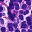

In [5]:
import pickle
with open('pcam_32_final.pickle', 'rb') as handle:
    final_pcam_32_loaded = pickle.load(handle)
final_pcam_32_loaded["val_images_32"][0]

In [6]:
final_pcam_32_loaded["test_images_numpy_32"][0]

array([[[ 84,  33,  52],
        [154, 112, 136],
        [ 71,  42,  73],
        ...,
        [159,  91, 142],
        [162,  99, 144],
        [166, 110, 149]],

       [[ 59,   3,  32],
        [165, 116, 146],
        [178, 143, 176],
        ...,
        [182, 114, 161],
        [161,  99, 138],
        [201, 144, 177]],

       [[ 64,   2,  41],
        [127,  75, 111],
        [224, 185, 216],
        ...,
        [142,  80, 117],
        [194, 135, 165],
        [254, 200, 224]],

       ...,

       [[ 53,  12,  46],
        [ 70,  20,  55],
        [197, 140, 173],
        ...,
        [255, 236, 251],
        [255, 231, 246],
        [239, 208, 224]],

       [[ 62,  23,  68],
        [ 47,   0,  44],
        [191, 138, 180],
        ...,
        [255, 246, 255],
        [199, 167, 190],
        [ 88,  53,  75]],

       [[ 54,  21,  74],
        [ 50,  10,  62],
        [209, 163, 210],
        ...,
        [248, 219, 249],
        [ 75,  36,  65],
        [ 92,  47,  76]]

In [8]:
print(len(final_pcam_32_loaded["test_images_numpy_32"]))
print(len(final_pcam_32_loaded["val_images_numpy_32"]))
print(len(final_pcam_32_loaded["val_images_32"]))
print(len(final_pcam_32_loaded["test_images_32"]))
print(len(final_pcam_32_loaded["test_labels_numpy"]))
print(len(final_pcam_32_loaded["val_labels_numpy"]))

19998
19998
19998
19998
19998
19998


# Load Data

In [9]:
def get_tfds_dataset(name):
  ds_train, ds_test = tfds.as_numpy(
      tfds.load(
          name,
          split=['train', 'test'],
          batch_size=-1,
          as_dataset_kwargs={'shuffle_files': False}))

  return ds_train['image'], ds_train['label'], ds_test['image'], ds_test['label']

def one_hot(x,
            num_classes,
            center=True,
            dtype=np.float32):
  assert len(x.shape) == 1
  one_hot_vectors = np.array(x[:, None] == np.arange(num_classes), dtype)
  if center:
    one_hot_vectors = one_hot_vectors - 1. / num_classes
  return one_hot_vectors

def get_normalization_data(arr):
  channel_means = np.mean(arr, axis=(0, 1, 2))
  channel_stds = np.std(arr, axis=(0, 1, 2))
  return channel_means, channel_stds

def normalize(array, mean, std):
  return (array - mean) / std

def unnormalize(array, mean, std):
  return (array * std) + mean


X_TRAIN_RAW = final_pcam_32_loaded["val_images_numpy_32"]
LABELS_TRAIN = final_pcam_32_loaded["val_labels_numpy"]
X_TEST_RAW = final_pcam_32_loaded["test_images_numpy_32"]
LABELS_TEST = final_pcam_32_loaded["test_labels_numpy"]
channel_means, channel_stds = get_normalization_data(X_TRAIN_RAW)
X_TRAIN, X_TEST = normalize(X_TRAIN_RAW, channel_means, channel_stds), normalize(X_TEST_RAW, channel_means, channel_stds) 
Y_TRAIN, Y_TEST = one_hot(LABELS_TRAIN, 2), one_hot(LABELS_TEST, 2) 

Augmentation class used to augment images

In [10]:
@dataclasses.dataclass
class Augmentor:
  """Class for creating augmentation function."""

  # function applied after augmentations (maps uint8 image to float image)
  # if standard preprocessing, this should be function which does channel-wise
  # standardization
  preprocessing_function: Callable[[np.ndarray], np.ndarray]

  # need this to unnormalize images if they are already normalized
  # before applying augmentations
  channel_means: Optional[np.ndarray] = None
  channel_stds: Optional[np.ndarray] = None

  # Specify these to augment at custom rate
  augmentation_frac: float = 1.0
  rotation_range: float = 0.0
  width_shift_range: float = 0.0
  height_shift_range: float = 0.0
  horizontal_flip: bool = False
  channel_shift_range: float = 0.0

  def __post_init__(self):
    self.aug_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=self.rotation_range,
        width_shift_range=self.width_shift_range,
        height_shift_range=self.height_shift_range,
        horizontal_flip=self.horizontal_flip,
        channel_shift_range=self.channel_shift_range,
        preprocessing_function=self.preprocessing_function,
    )

  def __call__(self,
               x: np.ndarray,
               normalized: bool = True,
               seed: Optional[int] = None):
    """Augments a numpy array of images.

    Args:
      x: image array (B,H,W,C)
      normalized: if True, then image is assumed to be standard preprocessed and
        therefore must be unnormalized before augmented
      seed: random seed for augmentations

    Returns:
      augmented images
    """

    if self.augmentation_frac == 0.0:
      return x

    permutation = np.random.permutation(x.shape[0])
    inv_permutation = get_inverse_permutation(permutation)
    num_aug_images = int(self.augmentation_frac * x.shape[0])

    x = x[permutation]
    if normalized:
      x_raw = unnormalize(x, self.channel_means, self.channel_stds)
    else:
      x_raw = x

    iterator = self.aug_generator.flow(  # pytype: disable=attribute-error
        x_raw[:num_aug_images],
        batch_size=num_aug_images,
        shuffle=False,
        seed=seed)
    x_aug = next(iterator)
    x_aug = np.concatenate([x_aug, x[num_aug_images:]])
    return x_aug[inv_permutation]

def get_inverse_permutation(perm):
  array = np.zeros_like(perm)
  array[perm] = np.arange(len(perm), dtype=int)
  return array

# Define Kernel

In [11]:
# define architectures

def FullyConnectedNetwork( 
    depth,
    width,
    W_std = np.sqrt(2), 
    b_std = 0.1,
    num_classes = 2,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax fully connected network."""
  activation_fn = stax.Relu()
  dense = functools.partial(
      stax.Dense, W_std=W_std, b_std=b_std, parameterization=parameterization)

  layers = [stax.Flatten()]
  for _ in range(depth):
    layers += [dense(width), activation_fn]
  layers += [stax.Dense(num_classes, W_std=W_std, b_std=b_std, 
                        parameterization=parameterization)]

  return stax.serial(*layers)

def FullyConvolutionalNetwork( 
    depth,
    width,
    W_std = np.sqrt(2), 
    b_std = 0.1,
    num_classes = 2,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax fully convolutional network."""
  activation_fn = stax.Relu()
  conv = functools.partial(
      stax.Conv,
      W_std=W_std,
      b_std=b_std,
      padding='SAME',
      parameterization=parameterization)

  for _ in range(depth):
    layers += [conv(width, (3,3)), activation_fn]
  layers += [stax.Flatten(), stax.Dense(num_classes, W_std=W_std, b_std=b_std,
                                        parameterization=parameterization)]

  return stax.serial(*layers)

def MyrtleNetwork(  
    depth,
    width,
    W_std = np.sqrt(2), 
    b_std = 0.1,
    num_classes = 2,
    parameterization = 'ntk',
    activation = 'relu'):
  """Returns neural_tangents.stax Myrtle network."""
  layer_factor = {5: [1, 1, 1], 7: [1, 2, 2], 10: [2, 3, 3]}
  if depth not in layer_factor.keys():
    raise NotImplementedError(
        'Myrtle network withd depth %d is not implemented!' % depth)
  activation_fn = stax.Relu()
  layers = []
  conv = functools.partial(
      stax.Conv,
      W_std=W_std,
      b_std=b_std,
      padding='SAME',
      parameterization=parameterization)
  layers += [conv(width, (3, 3)), activation_fn]

  # generate blocks of convolutions followed by average pooling for each
  # layer of layer_factor except the last
  for block_depth in layer_factor[depth][:-1]:
    for _ in range(block_depth):
      layers += [conv(width, (3, 3)), activation_fn]
    layers += [stax.AvgPool((2, 2), strides=(2, 2))]

  # generate final blocks of convolution followed by global average pooling
  for _ in range(layer_factor[depth][-1]):
    layers += [conv(width, (3, 3)), activation_fn]
  layers += [stax.GlobalAvgPool()]

  layers += [
      stax.Dense(num_classes, W_std, b_std, parameterization=parameterization)
  ]

  return stax.serial(*layers)

def get_kernel_fn(architecture, depth, width, parameterization):
  if architecture == 'FC':
    return FullyConnectedNetwork(depth=depth, width=width, parameterization=parameterization)
  elif architecture == 'Conv':
    return FullyConvolutionalNetwork(depth=depth, width=width, parameterization=parameterization)
  elif architecture == 'Myrtle':
    return MyrtleNetwork(depth=depth, width=width, parameterization=parameterization)
  else:
    raise NotImplementedError(f'Unrecognized architecture {architecture}')

In [12]:
_, _, kernel_fn = get_kernel_fn(ARCHITECTURE, DEPTH, WIDTH, PARAMETERIZATION)
KERNEL_FN = jax.jit(functools.partial(kernel_fn, get='ntk'))

# Run KIP

In [13]:
def class_balanced_sample(sample_size: int, 
                          labels: np.ndarray,
                          *arrays: np.ndarray, **kwargs: int):
  """Get random sample_size unique items consistently from equal length arrays.

  The items are class_balanced with respect to labels.

  Args:
    sample_size: Number of elements to get from each array from arrays. Must be
      divisible by the number of unique classes
    labels: 1D array enumerating class label of items
    *arrays: arrays to sample from; all have same length as labels
    **kwargs: pass in a seed to set random seed

  Returns:
    A tuple of indices sampled and the corresponding sliced labels and arrays
  """
  if labels.ndim != 1:
    raise ValueError(f'Labels should be one-dimensional, got shape {labels.shape}')
  n = len(labels)
  if not all([n == len(arr) for arr in arrays[1:]]):
    raise ValueError(f'All arrays to be subsampled should have the same length. Got lengths {[len(arr) for arr in arrays]}')
  classes = np.unique(labels)
  n_classes = len(classes)
  n_per_class, remainder = divmod(sample_size, n_classes)
  if remainder != 0:
    raise ValueError(
        f'Number of classes {n_classes} in labels must divide sample size {sample_size}.'
    )
  if kwargs.get('seed') is not None:
    np.random.seed(kwargs['seed'])
  inds = np.concatenate([
      np.random.choice(np.where(labels == c)[0], n_per_class, replace=False)
      for c in classes
  ])
  return (inds, labels[inds].copy()) + tuple(
      [arr[inds].copy() for arr in arrays])

def make_loss_acc_fn(kernel_fn):

  @jax.jit
  def loss_acc_fn(x_support, y_support, x_target, y_target, reg=1e-6):
    y_support = jax.lax.cond(LEARN_LABELS, lambda y: y, jax.lax.stop_gradient, y_support)
    k_ss = kernel_fn(x_support, x_support)
    k_ts = kernel_fn(x_target, x_support)
    k_ss_reg = (k_ss + jnp.abs(reg) * jnp.trace(k_ss) * jnp.eye(k_ss.shape[0]) / k_ss.shape[0])
    pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))
    mse_loss = 0.5*jnp.mean((pred - y_target) ** 2)
    acc = jnp.mean(jnp.argmax(pred, axis=1) == jnp.argmax(y_target, axis=1))
    return mse_loss, acc

  return loss_acc_fn

def get_update_functions(init_params, kernel_fn, lr):
  opt_init, opt_update, get_params = optimizers.adam(lr) 
  opt_state = opt_init(init_params)
  loss_acc_fn = make_loss_acc_fn(kernel_fn)
  value_and_grad = jax.value_and_grad(lambda params, x_target, y_target: loss_acc_fn(params['x'],
                                                                       params['y'],
                                                                       x_target,
                                                                       y_target), has_aux=True)

  @jax.jit
  def update_fn(step, opt_state, params, x_target, y_target):
    (loss, acc), dparams = value_and_grad(params, x_target, y_target)
    return opt_update(step, dparams, opt_state), (loss, acc)

  return opt_state, get_params, update_fn

def train(num_train_steps, log_freq=20, seed=1):

  _, labels_init, x_init_raw, y_init = class_balanced_sample(SUPPORT_SIZE, LABELS_TRAIN, X_TRAIN_RAW, Y_TRAIN, seed=seed)
  x_init = normalize(x_init_raw, channel_means, channel_stds)
  params_init = {'x': x_init, 'y': y_init}
  params_init_raw = {'x': x_init_raw, 'y': labels_init}

  opt_state, get_params, update_fn = get_update_functions(params_init, KERNEL_FN, LEARNING_RATE)
  params = get_params(opt_state)
  loss_acc_fn = make_loss_acc_fn(KERNEL_FN)

  test_loss, test_acc = loss_acc_fn(params['x'], params['y'], X_TEST, Y_TEST)  # compute in batches for expensive kernels
  print('initial test loss:', test_loss)
  print('initial test acc:', test_acc)
  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for i in range(1,num_train_steps+1):
    # full batch gradient descent
    _, _, x_target_batch, y_target_batch = class_balanced_sample(TARGET_BATCH_SIZE, LABELS_TRAIN, X_TRAIN, Y_TRAIN) 
    opt_state, aux = update_fn(i, opt_state, params, x_target_batch, y_target_batch)
    train_loss, train_acc = aux
    params = get_params(opt_state)
    test_loss, test_acc = loss_acc_fn(params['x'], params['y'], X_TEST, Y_TEST)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if i % log_freq == 0:
      print(f'----step {i}:')
      print('train loss:', train_loss)
      print('train acc:', train_acc)
        # compute in batches for expensive kernels
      print('test loss:', test_loss)
      print('test acc:', test_acc)

  return params, params_init, params_init_raw, train_losses, train_accs, test_losses, test_accs

def train_RANDOM(num_train_steps, log_freq=20, seed=1):

  _, labels_init_RANDOM, x_init_raw_RANDOM, y_init_RANDOM = class_balanced_sample(SUPPORT_SIZE, LABELS_TRAIN_RANDOM, X_TRAIN_RAW_RANDOM, Y_TRAIN_RANDOM, seed=seed)
  x_init_RANDOM = normalize(x_init_raw_RANDOM, channel_means_RANDOM, channel_stds_RANDOM)
  params_init_RANDOM = {'x': x_init_RANDOM, 'y': y_init_RANDOM}
  params_init_raw_RANDOM = {'x': x_init_raw_RANDOM, 'y': labels_init_RANDOM}

  opt_state, get_params, update_fn = get_update_functions(params_init_RANDOM, KERNEL_FN, LEARNING_RATE)
  params = get_params(opt_state)
  loss_acc_fn = make_loss_acc_fn(KERNEL_FN)

  test_loss, test_acc = loss_acc_fn(params['x'], params['y'], X_TEST, Y_TEST)  # compute in batches for expensive kernels
  print('initial test loss:', test_loss)
  print('initial test acc:', test_acc)
  train_losses = []
  train_accs = []
  test_losses = []
  test_accs = []
  for i in range(1,num_train_steps+1):
    # full batch gradient descent
    _, _, x_target_batch, y_target_batch = class_balanced_sample(TARGET_BATCH_SIZE, LABELS_TRAIN, X_TRAIN, Y_TRAIN) 
    opt_state, aux = update_fn(i, opt_state, params, x_target_batch, y_target_batch)
    train_loss, train_acc = aux
    params = get_params(opt_state)
    test_loss, test_acc = loss_acc_fn(params['x'], params['y'], X_TEST, Y_TEST)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    if i % log_freq == 0:
      print(f'----step {i}:')
      print('train loss:', train_loss)
      print('train acc:', train_acc)
        # compute in batches for expensive kernels
      print('test loss:', test_loss)
      print('test acc:', test_acc)

  return params, params_init_RANDOM, params_init_raw_RANDOM, train_losses, train_accs, test_losses, test_accs

## Run KIP 

In [14]:
params_final, params_init_RANDOM, params_init_raw_RANDOM, train_losses, train_accs, test_losses, test_accs = train(1000)

<ipython-input-13-7aaa7a3190e7>:47: FutureWarning: The sym_pos argument to solve() is deprecated and will be removed in a future JAX release. Use assume_a='pos' instead.
  pred = jnp.dot(k_ts, sp.linalg.solve(k_ss_reg, y_support, sym_pos=True))


initial test loss: 0.18109386126004046
initial test acc: 0.37643763
----step 20:
train loss: 0.10779223290453019
train acc: 0.59000003
test loss: 0.10106957131306275
test acc: 0.6419642
----step 40:
train loss: 0.10037952258722521
train acc: 0.674
test loss: 0.09856017103399024
test acc: 0.6688669
----step 60:
train loss: 0.09486342118066206
train acc: 0.73
test loss: 0.09610206602587777
test acc: 0.69131917
----step 80:
train loss: 0.08948685790644441
train acc: 0.76400006
test loss: 0.0973749852652798
test acc: 0.709771
----step 100:
train loss: 0.08415511660319962
train acc: 0.78000003
test loss: 0.0956208392102454
test acc: 0.70547056
----step 120:
train loss: 0.08270036597908965
train acc: 0.79800004
test loss: 0.09516264592532812
test acc: 0.7118712
----step 140:
train loss: 0.07955018152015046
train acc: 0.81200004
test loss: 0.09605106609006293
test acc: 0.70822084
----step 160:
train loss: 0.0843556364182946
train acc: 0.772
test loss: 0.0966791527152948
test acc: 0.6966197
--

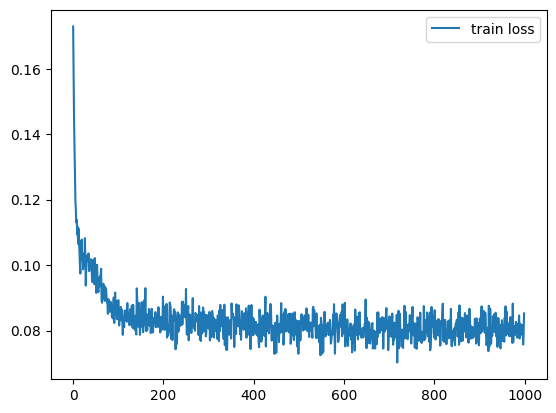

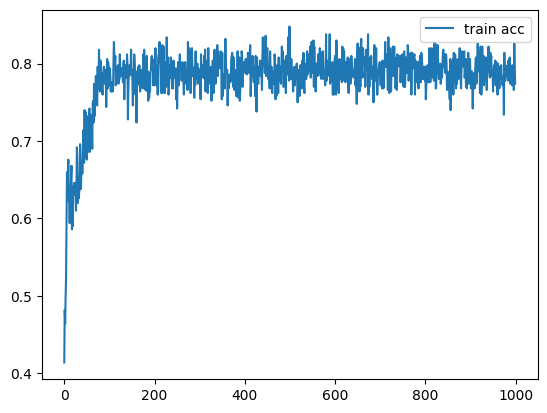

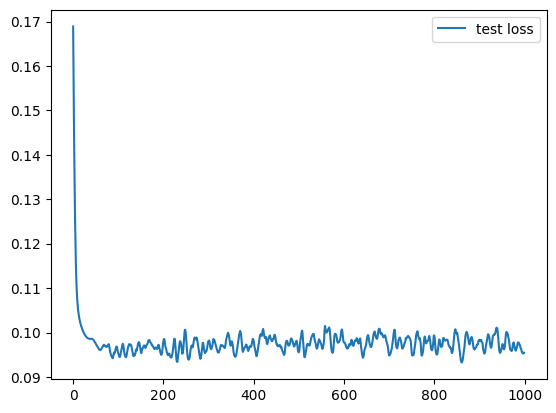

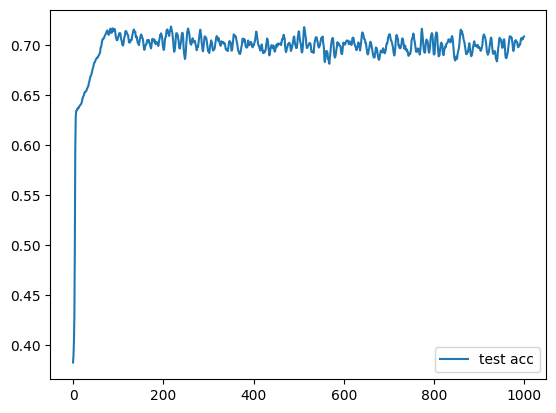

In [15]:
#train_losses, train_accs, test_losses, test_accs
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train loss')
plt.legend()
plt.show()
plt.plot(train_accs, label='train acc')
plt.legend()
plt.show()
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()
plt.plot(test_accs, label='test acc')
plt.legend()
plt.show()

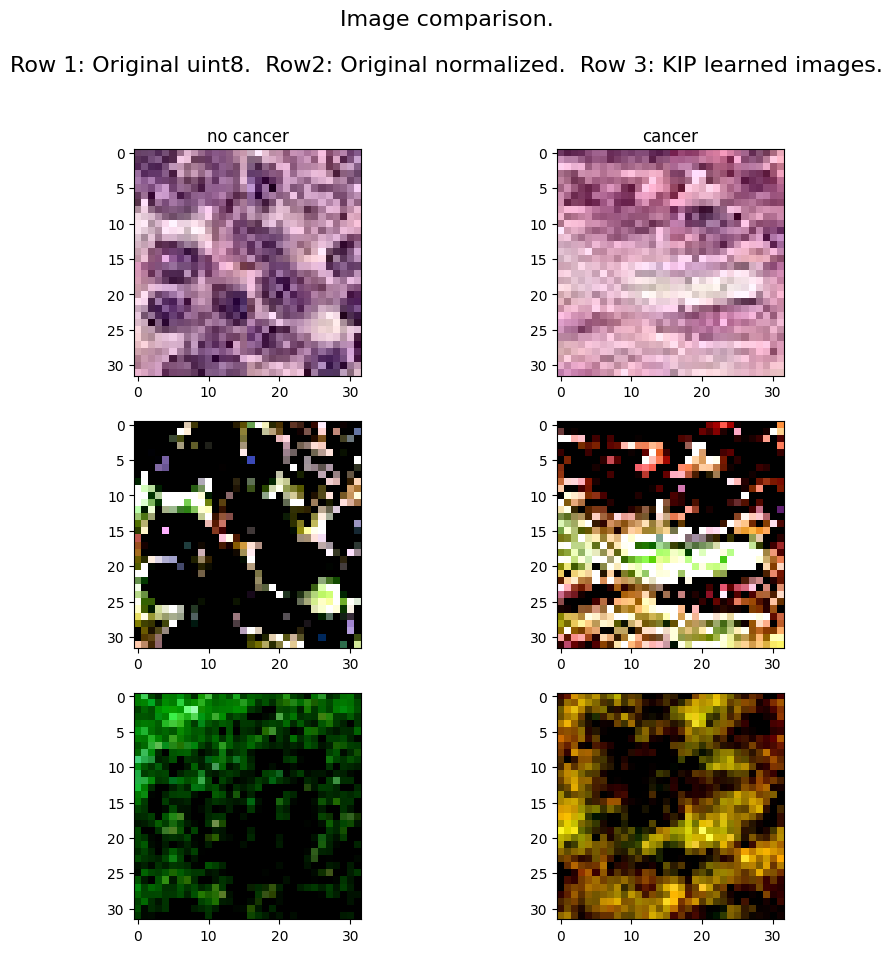

In [16]:
_, _, sample_raw, sample_init, sample_final = class_balanced_sample(2, params_init_raw_RANDOM['y'], params_init_raw_RANDOM['x'], params_init_RANDOM['x'], params_final['x'], seed=3)
class_names = ['no cancer','cancer']

fig = plt.figure(figsize=(10,10))
fig.suptitle('Image comparison.\n\nRow 1: Original uint8.  Row2: Original normalized.  Row 3: KIP learned images.', fontsize=16, y=1.02)
for i, img in enumerate(sample_raw):
  ax = plt.subplot(3, 2, i+1)
  ax.set_title(class_names[i])
  plt.imshow(np.squeeze(img))

for i, img in enumerate(sample_init, 1):
  plt.subplot(3, 2, 2+i)
  plt.imshow(np.squeeze(img))

for i, img in enumerate(sample_final, 1):
  plt.subplot(3, 2, 4+i)
  plt.imshow(np.squeeze(img))

In [17]:
import pickle 
dictionary = params_final
with open('saved_dictionary_10000.pkl', 'wb') as f:
    pickle.dump(dictionary, f)
        
with open('saved_dictionary_10000.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

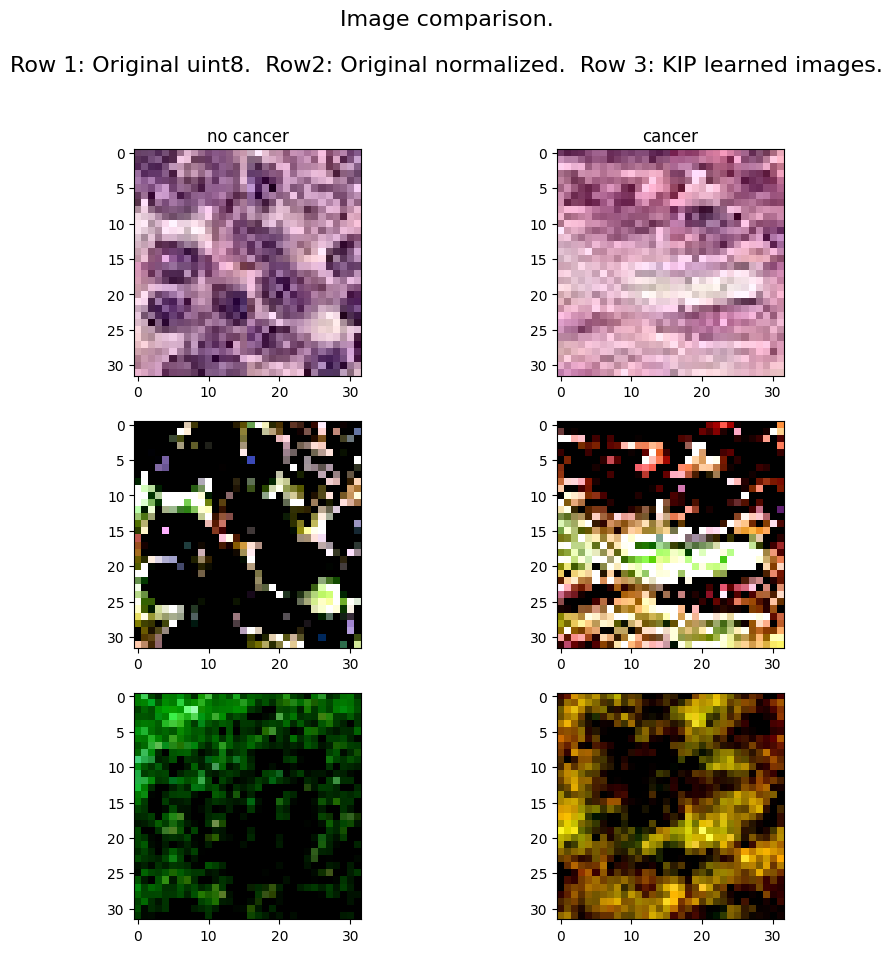

In [18]:
_, _, sample_raw, sample_init, sample_final = class_balanced_sample(2, params_init_raw_RANDOM['y'], params_init_raw_RANDOM['x'], params_init_RANDOM['x'], loaded_dict['x'], seed=3)
class_names = ['no cancer','cancer']

fig = plt.figure(figsize=(10,10))
fig.suptitle('Image comparison.\n\nRow 1: Original uint8.  Row2: Original normalized.  Row 3: KIP learned images.', fontsize=16, y=1.02)
for i, img in enumerate(sample_raw):
  ax = plt.subplot(3, 2, i+1)
  ax.set_title(class_names[i])
  plt.imshow(np.squeeze(img))

for i, img in enumerate(sample_init, 1):
  plt.subplot(3, 2, 2+i)
  plt.imshow(np.squeeze(img))

for i, img in enumerate(sample_final, 1):
  plt.subplot(3, 2, 4+i)
  plt.imshow(np.squeeze(img))